# SA1 Group 1 e0420379 e0424649 e0543513 e0421650

In [1]:
import warnings
warnings.simplefilter("ignore")
import time
import random

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.eval_measures import rmse

import sklearn
from sklearn.linear_model import PoissonRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, TimeSeriesSplit, ParameterGrid
from sklearn.metrics import mean_absolute_error, r2_score

In [2]:
print("Statsmodels version: ", sm.__version__)
print("sklearn version: ", sklearn.__version__)
print("Pandas version: ", pd.__version__)
print("Numpy version: ", np.__version__)

Statsmodels version:  0.12.2
sklearn version:  1.0.2
Pandas version:  1.4.1
Numpy version:  1.22.3


In [3]:
# Setting a random seed

np.random.seed(42)
random.seed(42)

In [4]:
bike = pd.read_excel("Bike_Sharing(extra).xlsx", sheet_name=None)

In [5]:
bike_clean = bike["Bike_Sharing"]
bike_clean = bike_clean.drop(columns=["S_No", "index", "Date", "https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset"])
bike_clean.isna().sum()

Time            0
Date2           0
season          0
yr              0
mnth            0
day             0
hr              0
holiday         0
weekday         0
workingday      0
weathersit    165
temp          165
atemp         165
hum           165
windspeed     165
casual        165
registered    165
total         165
dtype: int64

In [6]:
cols_with_na = ["weathersit", "temp", "atemp", "hum", "windspeed", "casual", "registered", "total"]

for col in cols_with_na:
    bike_clean.loc[:, col] = bike_clean[col].fillna(bike_clean[col].median())

In [7]:
bike_clean.loc[:, "Time"] = pd.to_datetime(bike_clean["Time"])
bike_clean = bike_clean.sort_values(by="Time")

In [8]:
n_rows_train = round(len(bike_clean) * 0.7)

train = bike_clean.copy().iloc[:n_rows_train -1 , :]
test = bike_clean.copy().iloc[n_rows_train - 1:, :]

# EDA

In [9]:
train["weekday"].unique()

array([6, 0, 1, 2, 3, 4, 5], dtype=int64)

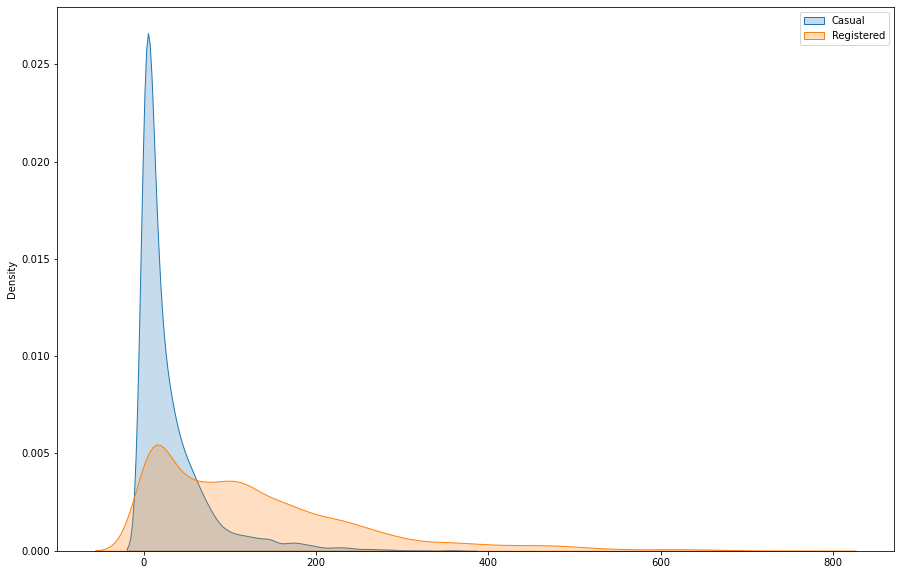

In [10]:
plt.figure(figsize=(15,10))
sns.kdeplot(data=train, x="casual", fill=True, label="Casual")
sns.kdeplot(data=train, x="registered", fill=True, label="Registered")
plt.xlabel("")
plt.legend()
plt.show()

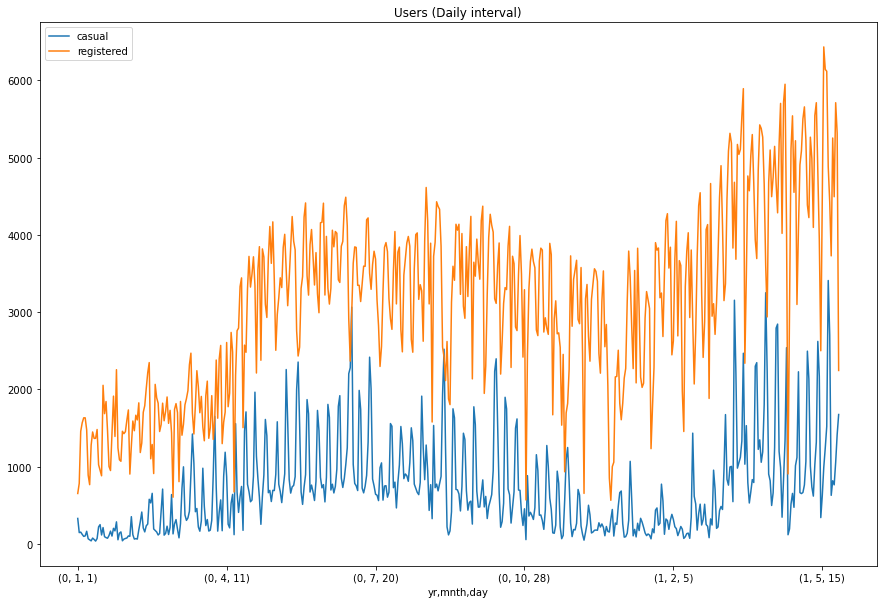

In [11]:
train.groupby(["yr", "mnth", "day"]).sum()[["casual", "registered"]].plot(figsize=(15,10))
plt.title("Users (Daily interval)")
plt.show()

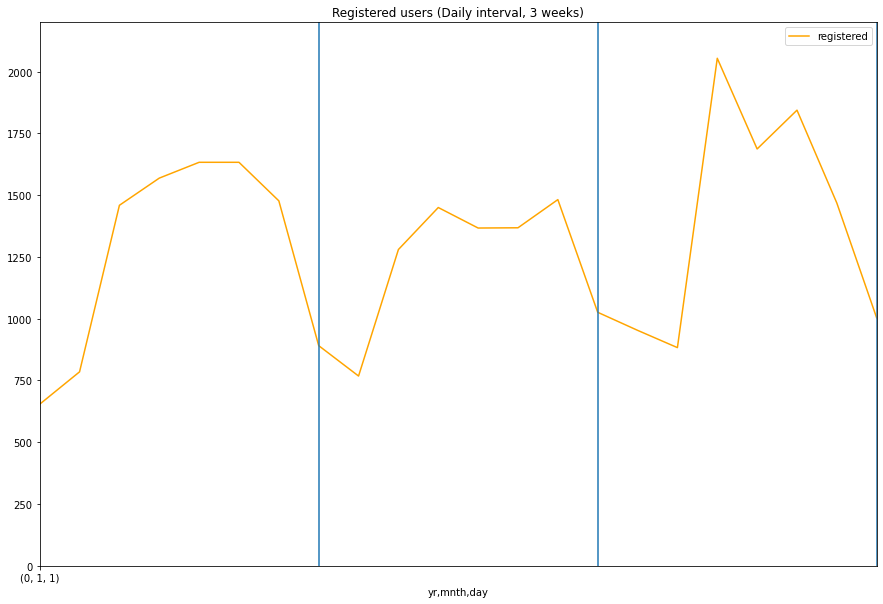

In [12]:
train.groupby(["yr", "mnth", "day"]).sum()[["registered"]].plot(figsize=(15,10), color="orange")
plt.title("Registered users (Daily interval, 3 weeks)")
plt.axvline(7)
plt.axvline(14)
plt.axvline(21)
plt.xlim(0, 21)
plt.ylim(0,2200)
plt.show()

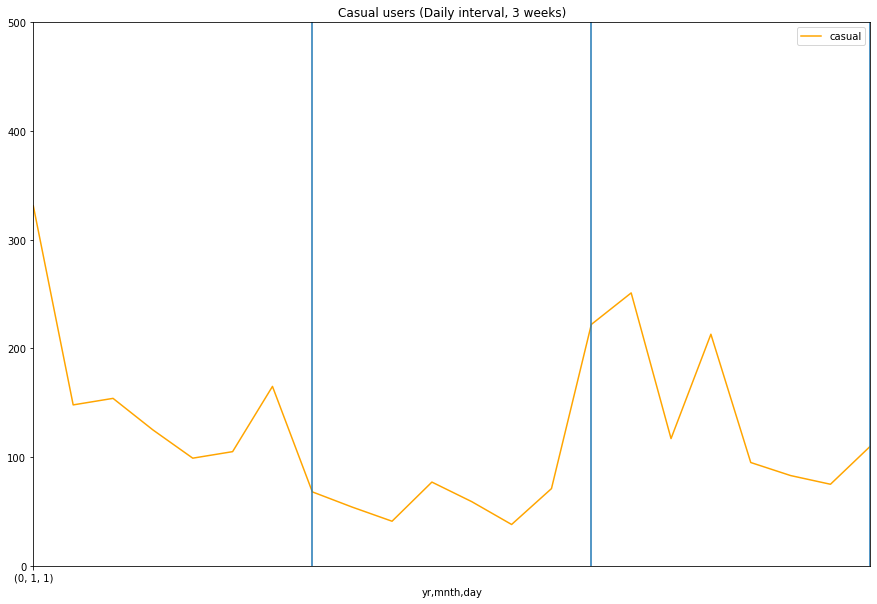

In [13]:
train.groupby(["yr", "mnth", "day"]).sum()[["casual"]].plot(figsize=(15,10), color="orange")
plt.title("Casual users (Daily interval, 3 weeks)")
plt.axvline(7)
plt.axvline(14)
plt.axvline(21)
plt.xlim(0, 21)
plt.ylim(0,500)
plt.show()

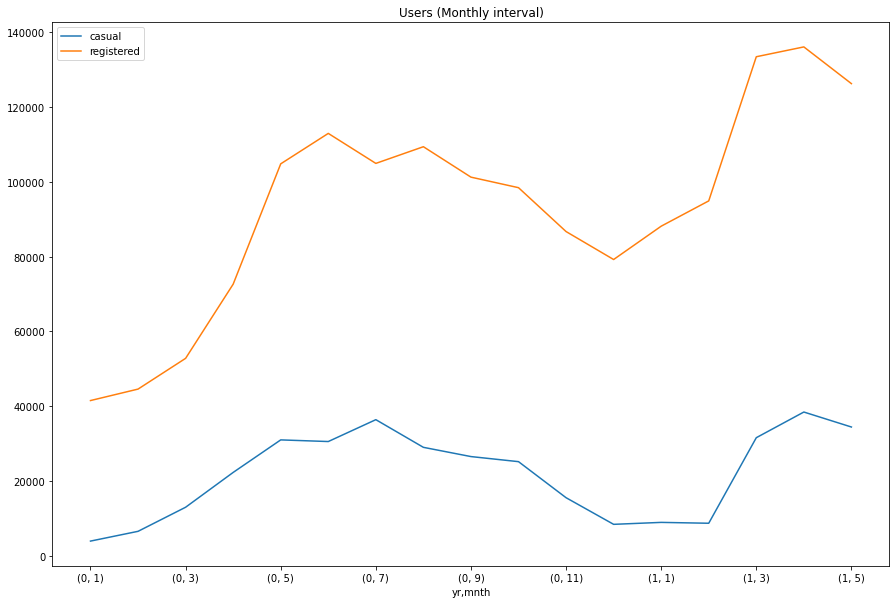

In [14]:
train.groupby(["yr", "mnth"]).sum()[["casual", "registered"]].plot(figsize=(15,10))
plt.title("Users (Monthly interval)")
plt.show()

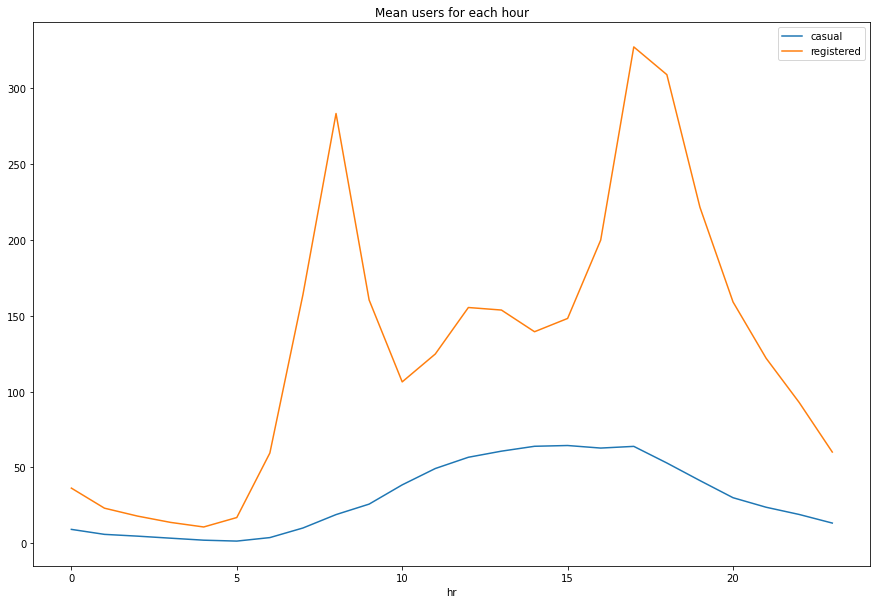

In [15]:
train.groupby("hr").mean()[["casual", "registered"]].plot(figsize=(15,10))
plt.title("Mean users for each hour")
plt.show()

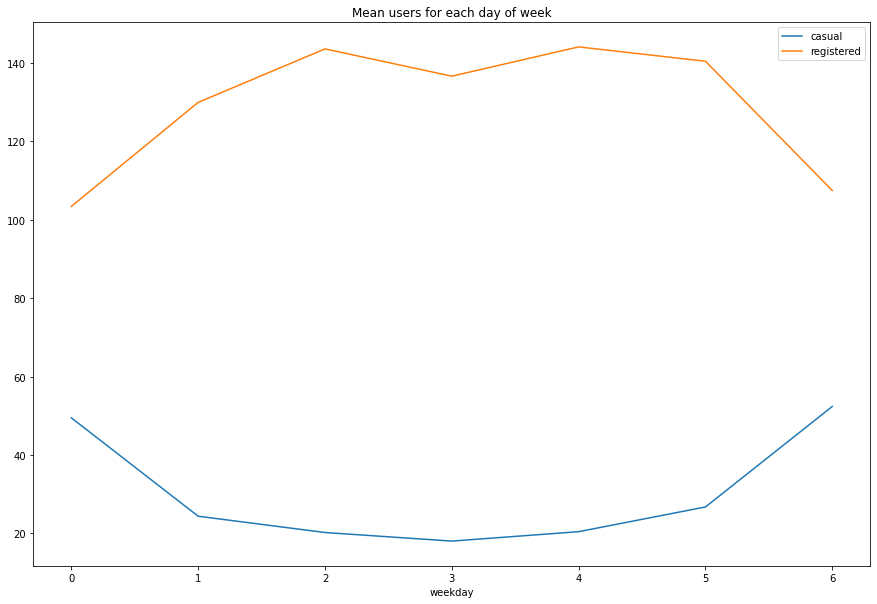

In [16]:
train.groupby("weekday").mean()[["casual", "registered"]].plot(figsize=(15,10))
plt.title("Mean users for each day of week")
plt.show()

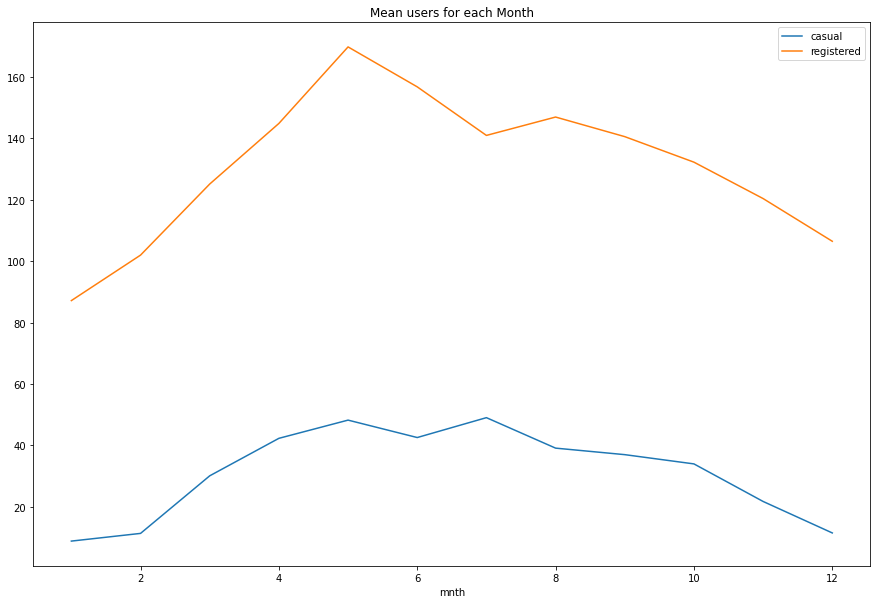

In [17]:
train.groupby("mnth").mean()[["casual", "registered"]].plot(figsize=(15,10))
plt.title("Mean users for each Month")
plt.show()

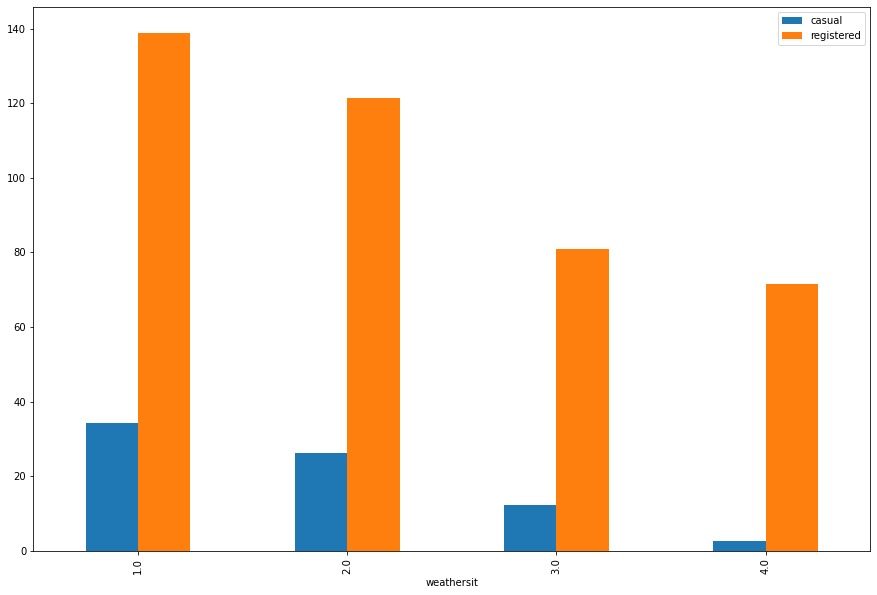

In [18]:
train.groupby("weathersit").mean()[["casual", "registered"]].plot.bar(figsize=(15,10))
plt.show()

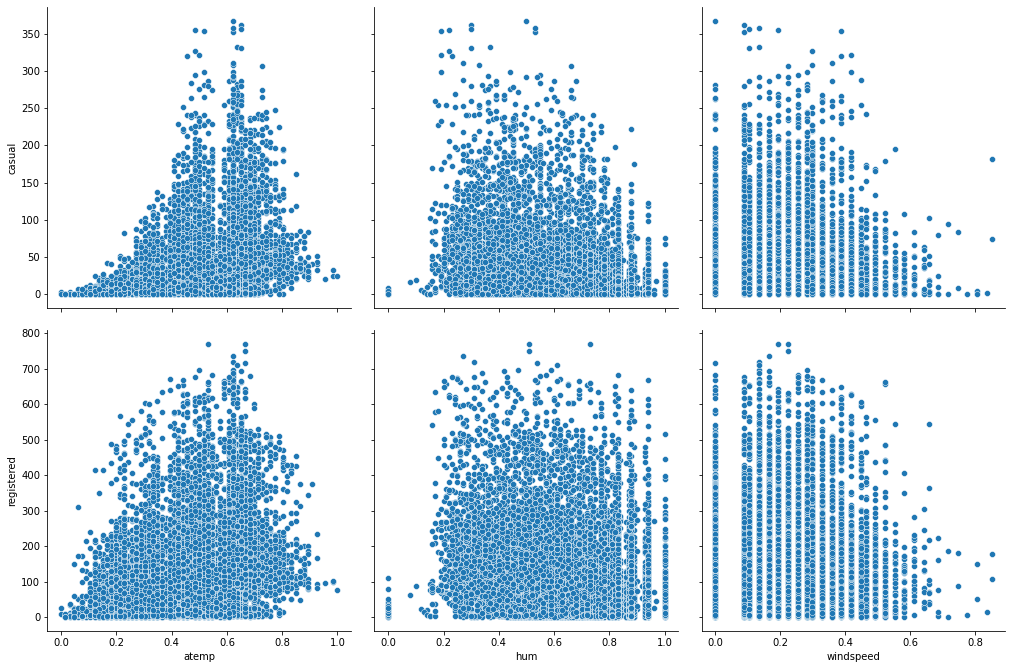

In [19]:
sns.pairplot(data=train, x_vars=["atemp", "hum", "windspeed"], y_vars=["casual", "registered"])
plt.gcf().set_size_inches(15,10)
plt.show()

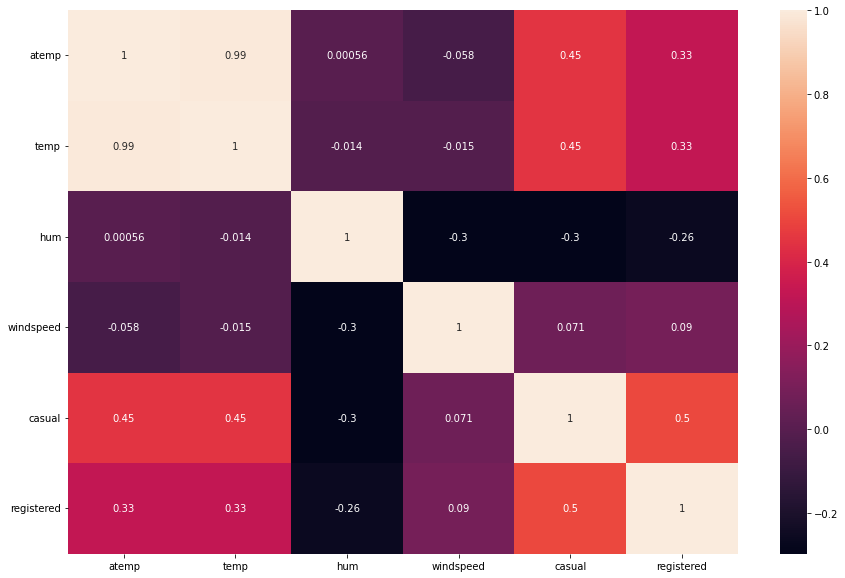

In [20]:
sns.heatmap(train[["atemp", "temp", "hum", "windspeed", "casual", "registered"]].corr(), annot=True)
plt.gcf().set_size_inches(15,10)
plt.show()

In [21]:
# dicky-fuller
adfuller(train["casual"])

(-10.815726511457886,
 1.8594166477799667e-19,
 40,
 12239,
 {'1%': -3.430884412292472,
  '5%': -2.861776183202108,
  '10%': -2.5668957152963654},
 97743.61905044976)

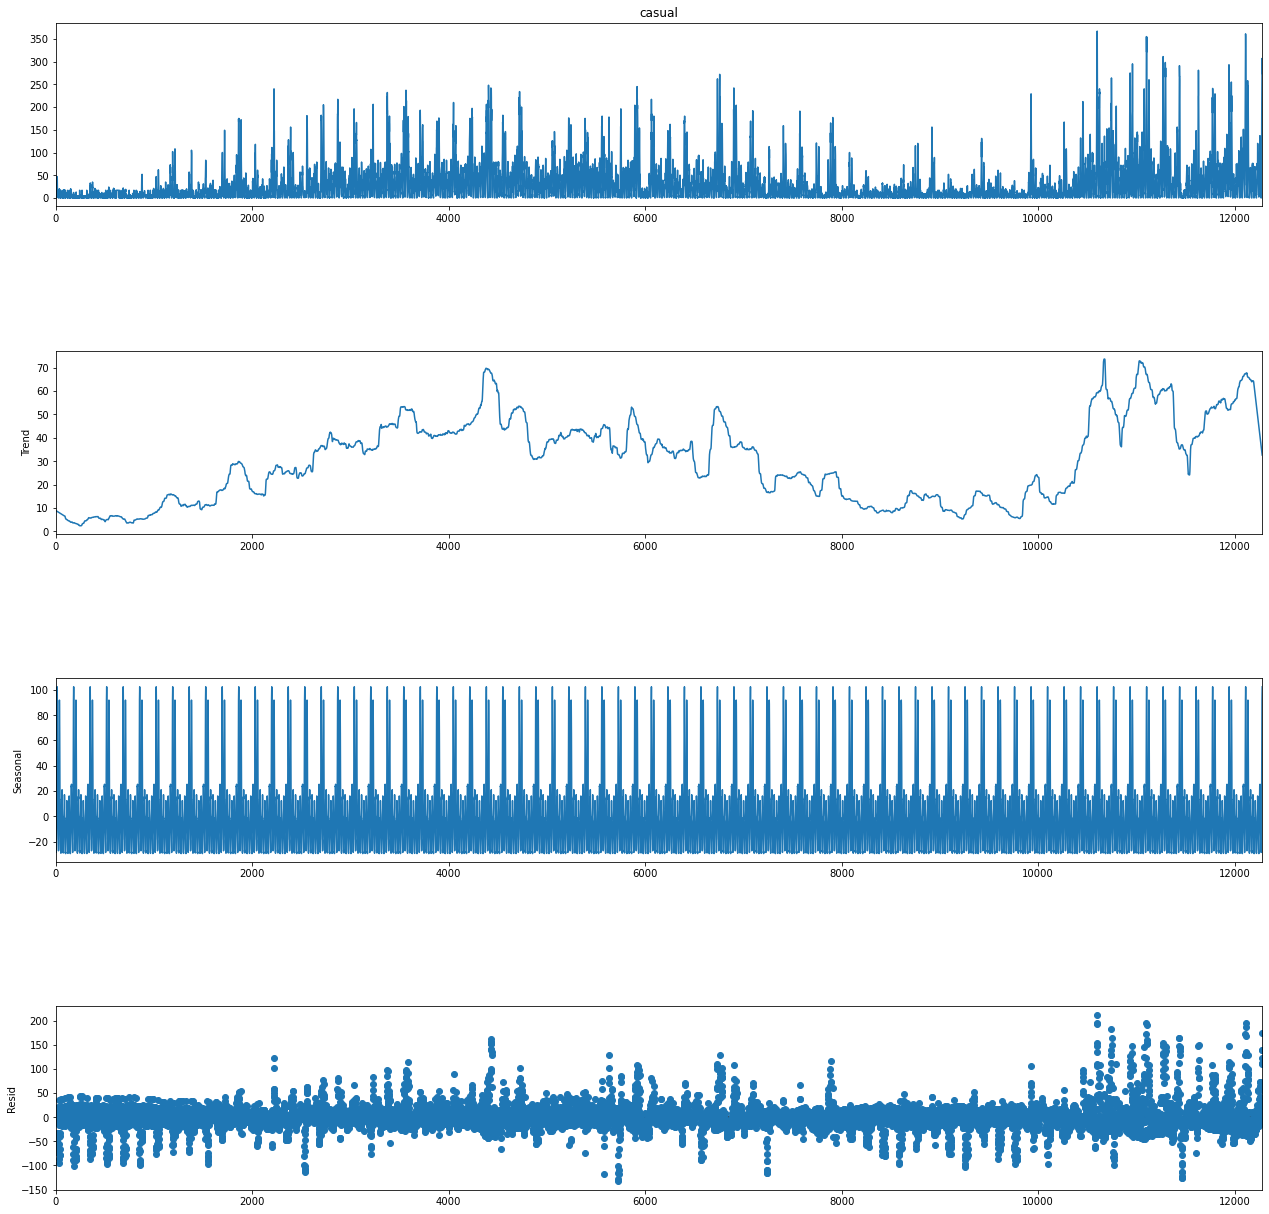

In [22]:
# decomposition - period of 24 hours

sd_casual = seasonal_decompose(train["casual"], model="add", period=24*7, extrapolate_trend=True)

sd_casual.plot()
plt.gcf().set_size_inches(20, 20)
plt.show()

In [23]:
adfuller(train["registered"])

(-8.713249883640888,
 3.5441266787402406e-14,
 40,
 12239,
 {'1%': -3.430884412292472,
  '5%': -2.861776183202108,
  '10%': -2.5668957152963654},
 129089.60913577827)

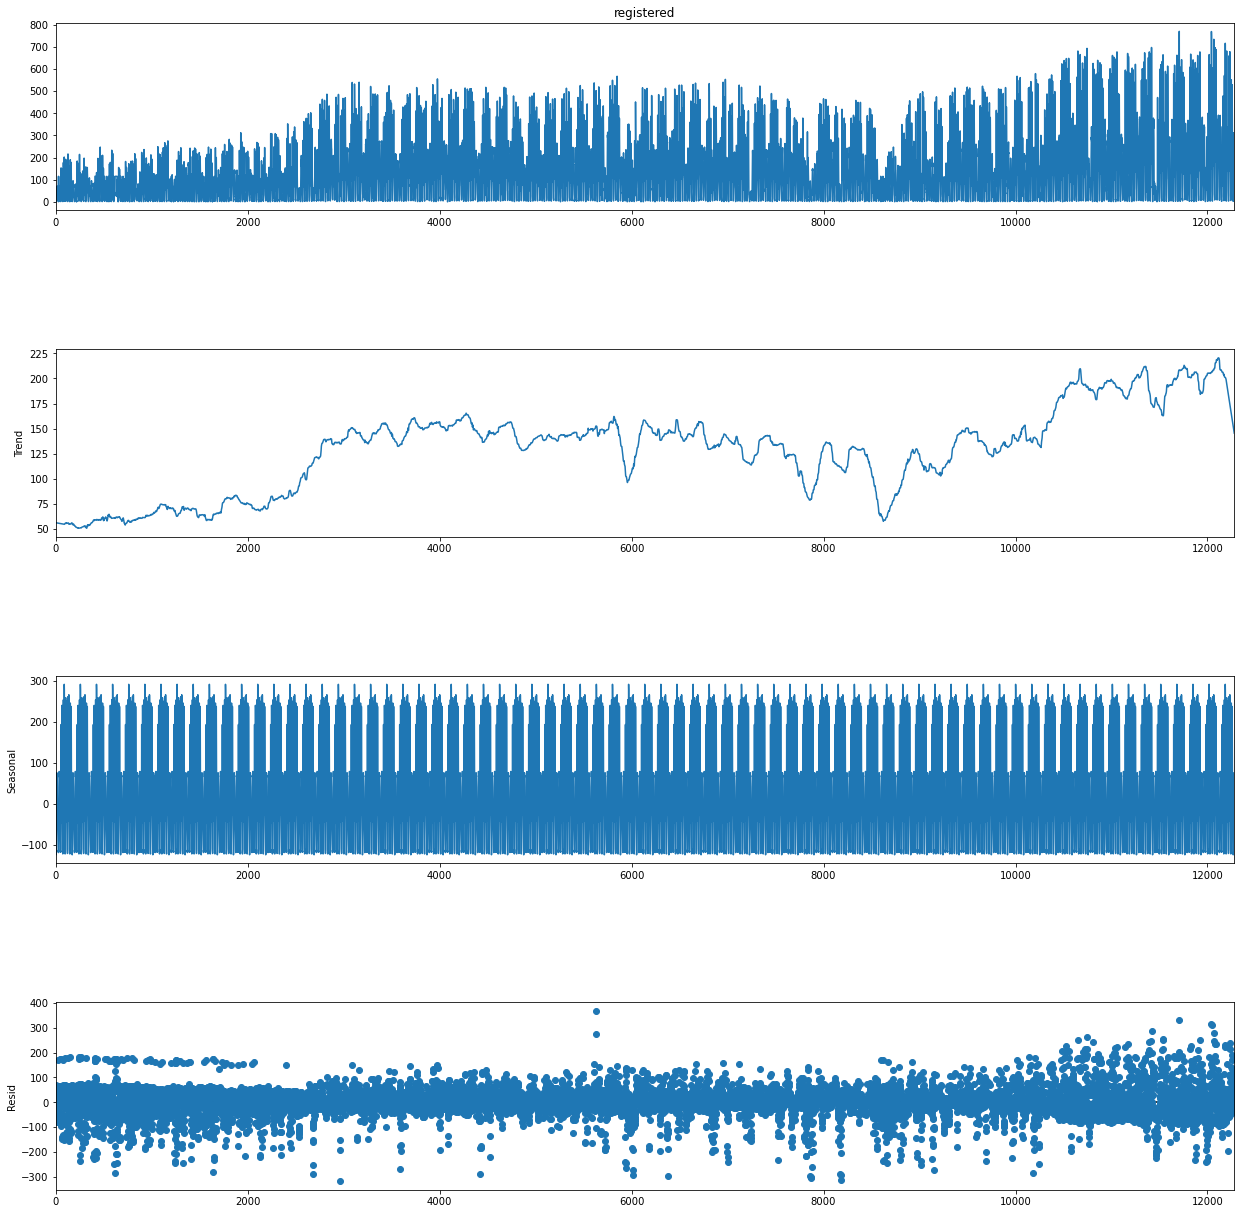

In [24]:
# decomposition - period of 24 hours

sd_registered = seasonal_decompose(train["registered"], model="add", period=24*7, extrapolate_trend=True)

sd_registered.plot()
plt.gcf().set_size_inches(20, 20)
plt.show()

# Models
3 approaches are tried
<br>
<ol>
    <li> GLM - Poisson and Negative Binomial </li>
    <li> Holt Winters Exponential Smoothing </li>
    <li> SARIMAX </li>
</ol>
<br>
Models are evaluated based on R2, Adjusted R2 (if applicable), RMSE and MAE.

### GLM

#### Casual

In [25]:
glm_train = train.copy()
glm_test = test.copy()

glm_X_train = glm_train.drop(columns=["Time", "Date2", "day", "total", "casual", "registered", "temp"])
glm_X_test = glm_test.drop(columns=["Time", "Date2", "day", "total", "casual", "registered", "temp"])

# Making dummy variables
categorical_vars = ["season", "yr", "mnth", "hr", "weekday", "weathersit"]
dummies = pd.get_dummies(bike_clean[categorical_vars].astype(str), drop_first=True)

dummies_train = dummies.iloc[:n_rows_train -1 , :]
dummies_test = dummies.iloc[n_rows_train - 1:, :]

glm_X_train = glm_X_train.join(dummies_train).drop(columns=categorical_vars)
glm_X_test = glm_X_test.join(dummies_test).drop(columns=categorical_vars)

glm_y_train_casual = glm_train["casual"]
glm_y_train_registered = glm_train["registered"]

In [26]:
print("Mean: ", glm_y_train_casual.mean(), "Std: ", glm_y_train_casual.std())

Mean:  30.263192182410425 Std:  43.87242401511558


The mean and standard deviation of the data suggests a negative binomial GLM may be more appropriate. However, since the range of the DV fit both Poisson and Negative Binomial, both are tried to see which gives better results.

In [27]:
# Helper function to score a statsmodel model

def score_model_train(model):
    # Use residuals and fitted values to calculate original actual values
    if hasattr(model, "resid_response"):
        actual = model.fittedvalues + model.resid_response
    else:
        actual = model.fittedvalues + model.resid
    
    rootmse = rmse(model.fittedvalues, actual)
    print('RMSE: ', rootmse)

    mae = mean_absolute_error(model.fittedvalues, actual)
    print('MAE: ', mae)
    
    r2 = r2_score(model.fittedvalues, actual)
    print('R2: ', r2)

    if hasattr(model, "resid_response"):
        p = len(model.tvalues)
        adj_r2 = 1-(1-r2)*(n_rows_train-1)/(n_rows_train-p-1) #n =no. of obs (test size), p = no. of predictor 
        print('Adjusted R2: ',adj_r2)

In [28]:
# Helper function to get Poisson GLM, given X and y
# Returns the glm and prints the RMSE
def get_nb_glm(X, y):
    glm = sm.GLM(y, sm.add_constant(X), family=sm.families.NegativeBinomial()).fit()
    
    score_model_train(glm)
    
    return glm

nb_casual_sm = get_nb_glm(glm_X_train, glm_y_train_casual)
print(nb_casual_sm.summary())

RMSE:  26.095530895078205
MAE:  12.90569470903641
R2:  0.638477361273224
Adjusted R2:  0.636910280235151
                 Generalized Linear Model Regression Results                  
Dep. Variable:                 casual   No. Observations:                12280
Model:                            GLM   Df Residuals:                    12228
Model Family:        NegativeBinomial   Df Model:                           51
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -45167.
Date:                Sat, 16 Apr 2022   Deviance:                       6962.0
Time:                        16:10:04   Pearson chi2:                 7.59e+03
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------

In [29]:
# Helper function to get Poisson GLM, given X and y
# Returns the glm and prints the RMSE
def get_poisson_glm(X, y):
    glm = sm.GLM(y, sm.add_constant(X), family=sm.families.Poisson()).fit()
    
    score_model_train(glm)
    
    return glm

# Casual
poisson_casual_sm = get_poisson_glm(glm_X_train, glm_y_train_casual)
print(poisson_casual_sm.summary())

RMSE:  19.68747129870261
MAE:  11.032753188312213
R2:  0.7455579291228616
Adjusted R2:  0.7444550069214639
                 Generalized Linear Model Regression Results                  
Dep. Variable:                 casual   No. Observations:                12280
Model:                            GLM   Df Residuals:                    12228
Model Family:                 Poisson   Df Model:                           51
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -71754.
Date:                Sat, 16 Apr 2022   Deviance:                       93088.
Time:                        16:10:08   Pearson chi2:                 1.07e+05
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------

In [30]:
def score_glm_test(glm, test_y, test_X):
    pred = glm.predict(sm.add_constant(test_X, has_constant="add"))
    
    rootmse = rmse(test_y, pred)
    print('RMSE: ', rootmse)

    mae = mean_absolute_error(test_y, pred)
    print('MAE: ', mae)
    
    r2 = r2_score(test_y, pred)
    print('R2: ', r2)

    p = len(test_X.columns)
    n_rows_test = len(test_y)
    adj_r2 = 1-(1-r2)*(n_rows_test-1)/(n_rows_test-p-1) #n =no. of obs (test size), p = no. of predictor 
    print('Adjusted R2: ',adj_r2)

score_glm_test(poisson_casual_sm, test["casual"], glm_X_test)

RMSE:  31.57237273292393
MAE:  17.517255873431647
R2:  0.700936701063177
Adjusted R2:  0.6979523810584342


In [31]:
# Helper function to get mean and std of 5-fold CV scores of Poisson regression
# Takes in X and y
def get_poisson_cv(X, y):
    glm = PoissonRegressor(alpha=0, max_iter=1000)
    glm_cv = cross_val_score(glm, X, y, scoring="neg_root_mean_squared_error")
    print("Mean CV RMSE: ",np.abs(glm_cv).mean(), "Std: ", glm_cv.std())
    
get_poisson_cv(glm_X_train, glm_y_train_casual)

Mean CV RMSE:  23.134174907486376 Std:  8.557806211170874


In [32]:
# Helper function to conduct gridsearch to find best values of alpha for regularization
# Takes in X, y, and grid
# Prints the best params and returns the gridsearch object
# Note, l2 regularization is conducted
# https://github.com/scikit-learn/scikit-learn/issues/22289
def get_poisson_gscv(X, y, grid):
    glm_reg = PoissonRegressor(max_iter=1000)
    gs = GridSearchCV(glm_reg, grid, scoring="neg_root_mean_squared_error").fit(X, y)
    
    print(gs.best_params_)
    
    return gs

In [33]:
grid1_casual = {"alpha": [0.01, 0.1, 1, 10, 100]}
gs1_casual = get_poisson_gscv(glm_X_train, glm_y_train_casual, grid1_casual)

{'alpha': 0.01}


In [34]:
grid2_casual = {"alpha": np.arange(0.005, 0.015, 0.001)}
gs2_casual = get_poisson_gscv(glm_X_train, glm_y_train_casual, grid2_casual)

{'alpha': 0.005}


In [35]:
grid3_casual = {"alpha": np.arange(0, 0.01, 0.001)}
gs3_casual = get_poisson_gscv(glm_X_train, glm_y_train_casual, grid3_casual)

{'alpha': 0.004}


In [36]:
print("Best CV score from gridsearch: ", np.abs(gs3_casual.best_score_))

Best CV score from gridsearch:  23.1008466416219


In [37]:
def score_gs_test(gs, test_y, test_X):
    pred = gs.predict(test_X)
    
    rootmse = rmse(test_y, pred)
    print('RMSE: ', rootmse)

    mae = mean_absolute_error(test_y, pred)
    print('MAE: ', mae)
    
    r2 = r2_score(test_y, pred)
    print('R2: ', r2)

    p = len(test_X.columns)
    n_rows_test = len(test_y)
    adj_r2 = 1-(1-r2)*(n_rows_test-1)/(n_rows_test-p-1) #n =no. of obs (test size), p = no. of predictor 
    print('Adjusted R2: ',adj_r2)

score_gs_test(gs3_casual, test["casual"], glm_X_test)

RMSE:  31.493342078460795
MAE:  17.510246231351086
R2:  0.7024320328935681
Adjusted R2:  0.6994626346418824


#### Registered

In [38]:
print("Mean: ", glm_y_train_registered.mean(), "Std: ", glm_y_train_registered.std())

Mean:  129.28599348534203 Std:  124.87977558802113


The range of values for registered users better fits a poisson GLM, but nonetheless, both negative binomial and poisson are tried as well.

In [39]:
nb_registered = get_nb_glm(glm_X_train, glm_y_train_registered)

print(nb_registered.summary())

RMSE:  70.67398338968152
MAE:  45.81170221075827
R2:  0.6146733196936958
Adjusted R2:  0.6130030560103528
                 Generalized Linear Model Regression Results                  
Dep. Variable:             registered   No. Observations:                12280
Model:                            GLM   Df Residuals:                    12228
Model Family:        NegativeBinomial   Df Model:                           51
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -66555.
Date:                Sat, 16 Apr 2022   Deviance:                       5420.6
Time:                        16:10:38   Pearson chi2:                 7.20e+03
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
---------------------

In [40]:
glm_y_train_registered = glm_train["registered"]
poisson_registered = get_poisson_glm(glm_X_train, glm_y_train_registered)

print(poisson_registered.summary())

RMSE:  58.02165601340852
MAE:  40.229466552305325
R2:  0.7173913910602269
Adjusted R2:  0.716166376234529
                 Generalized Linear Model Regression Results                  
Dep. Variable:             registered   No. Observations:                12280
Model:                            GLM   Df Residuals:                    12228
Model Family:                 Poisson   Df Model:                           51
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.8766e+05
Date:                Sat, 16 Apr 2022   Deviance:                   3.0141e+05
Time:                        16:10:42   Pearson chi2:                 3.48e+05
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
---------------------

In [41]:
score_glm_test(poisson_registered, test["registered"], glm_X_test)

RMSE:  104.31561481832438
MAE:  73.52456186601769
R2:  0.6870313339394795
Adjusted R2:  0.6839082537945654


In [42]:
get_poisson_cv(glm_X_train, glm_y_train_registered)

Mean CV RMSE:  68.18712331059467 Std:  12.54908575594577


In [43]:
grid1_registered = {"alpha": [0.01, 0.1, 1, 10, 100]}
gs1_registered = get_poisson_gscv(glm_X_train, glm_y_train_registered, grid1_registered)

{'alpha': 0.1}


In [44]:
grid2_registered = {"alpha": np.arange(0.05, 0.15, 0.01)}
gs2_registered = get_poisson_gscv(glm_X_train, glm_y_train_registered, grid2_registered)

{'alpha': 0.12000000000000001}


In [45]:
print("Best CV score from gridsearch: ", np.abs(gs2_registered.best_score_))

Best CV score from gridsearch:  67.59180210466604


In [46]:
score_gs_test(gs2_registered, test["registered"], glm_X_test)

RMSE:  102.35577669202989
MAE:  73.55534659996853
R2:  0.6986807130889905
Adjusted R2:  0.6956738808265893


#### GLM Discussion
Poisson seems to fit best for both casual and registered. Conducting L2 regularization further improves the generalizability of the poisson GLM. reduucing mean CV RMSE.
<br>
However, it is important to note that non-lagged features are used for these models. Hence, they do not have forecasting ability and serve more as an explanatory model which helps us understand how different characteristics of the day affect the number of casual and registered users on that day itself.

### Holt-Winters

#### Casual

In [47]:
# Helper function to get holt-winters model, given the time series data
# Plots the graph of fitted against actual
# And also prints the params and RMSE
# returns the hw model
def get_hw(ts_data, smoothing_level=None, smoothing_trend=None, smoothing_seasonal=None, damping_trend=None):
    hw = ExponentialSmoothing(ts_data, trend="add", seasonal="add", 
                              seasonal_periods=24*7, damped_trend=True).fit(smoothing_level, smoothing_trend, 
                                                                            smoothing_seasonal, damping_trend)
    ts_data.plot(figsize=(15,10), label="Actual")
    hw.fittedvalues.plot(figsize=(15,10), label="Fitted")
    plt.legend()
    plt.show()
    
    print(hw.params)
    score_model_train(hw)
    
    return hw

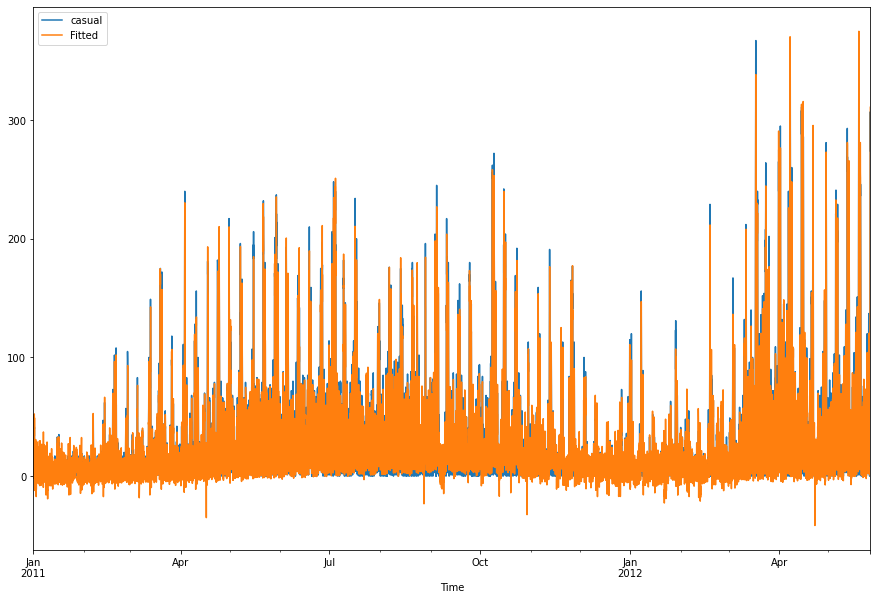

{'smoothing_level': 0.8698689708818864, 'smoothing_trend': 8.857129691914349e-05, 'smoothing_seasonal': 0.13013045750180685, 'damping_trend': 0.9788129656754398, 'initial_level': 14.936244196277173, 'initial_trend': 3.267491271760765, 'initial_seasons': array([-19.80389399, -25.58145215, -27.08002202, -31.4514997 ,
       -36.21328743, -33.72042744, -37.39737511, -29.12915329,
       -14.20599128,   5.76928727,  29.0493605 ,  42.74238849,
        46.1057449 ,  34.04450165,  40.59687191,  34.84195602,
        36.66540272,  42.24230541,  15.12687549,  -1.31094807,
       -19.73898447, -15.82562833, -20.92442009, -25.1772118 ,
       -21.21406657, -17.80039305, -20.3296378 , -27.94560873,
       -37.43728547, -46.18773416, -44.98862483, -46.43899145,
       -33.1482082 ,  -6.12878271,  18.31590036,  33.61502807,
        40.71346366,  44.69136851,  46.84453312,  33.0481585 ,
        27.49812846,  17.13976732,  -7.51286302, -16.79601004,
       -30.03416873, -35.24368114, -26.39035072, -21.

In [48]:
ts_train_casual = train[["Time", "casual"]].set_index("Time").asfreq("H").copy()
hw_casual = get_hw(ts_train_casual)

In [49]:
def score_model_test(model, test_y, test_X=None):

    if test_X is not None:
        pred = model.predict(start=test_y.index[0], end=test_y.index[-1], exog=test_X)
    else:
        pred = model.predict(start=test_y.index[0], end=test_y.index[-1])
    
    rootmse = rmse(test_y, pred)
    print('RMSE: ', rootmse)

    mae = mean_absolute_error(test_y, pred)
    print('MAE: ', mae)
    
    r2 = r2_score(test_y, pred)
    print('R2: ', r2)

    if test_X is not None:
        p = len(test_X.columns)
        n_rows_test = len(test_y)
        adj_r2 = 1-(1-r2)*(n_rows_test-1)/(n_rows_test-p-1) #n =no. of obs (test size), p = no. of predictor 
        print('Adjusted R2: ',adj_r2)

In [50]:
# Helper function to show forecast results, given the hw model and test data
def show_hw_fcast_res(hw, test):
    pred_test = hw.predict(start=test.index[0], end=test.index[-1])
    
    test.plot(figsize=(15,10), label="Actual")
    pred_test.plot(figsize=(15,10), label="Forecasted")
    plt.legend()
    plt.show()
    
    score_model_test(hw, test.iloc[:, -1])

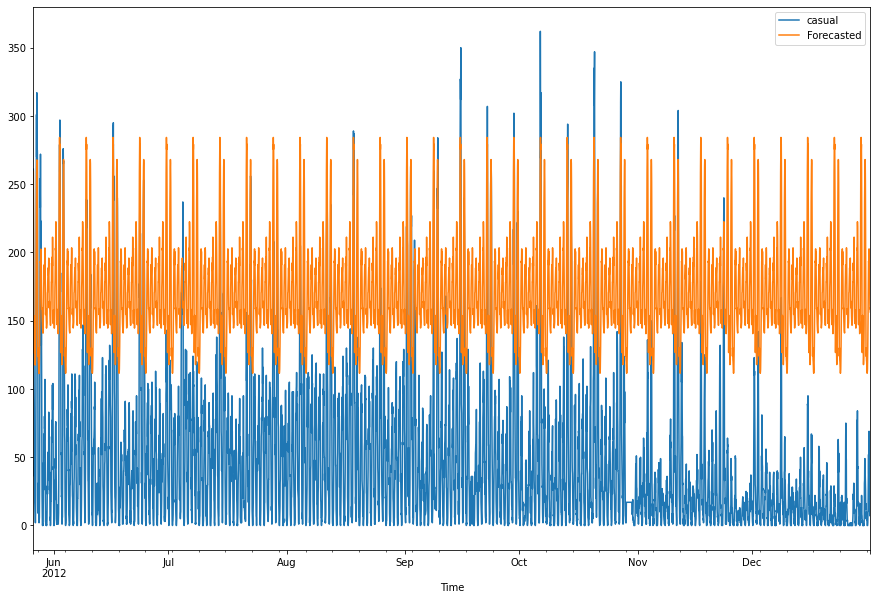

RMSE:  129.86788386572528
MAE:  124.55554558009405
R2:  -4.0600196689937045


In [51]:
ts_test_casual = test[["Time", "casual"]].set_index("Time").asfreq("H").copy()
show_hw_fcast_res(hw_casual, ts_test_casual)

In [52]:
# Time series split

# Helper function to get mean RMSE for holt winters, given the time series data and smoothing_{level, trend, seasonal} and damping_trend

def get_ts_cv(ts_data, smoothing_level=None, smoothing_trend=None, smoothing_seasonal=None, damping_trend=None):
    tscv = TimeSeriesSplit()
    rmses = []

    for train_index, test_index in tscv.split(ts_data):
        hw_tmp = ExponentialSmoothing(ts_data[train_index], trend="add", seasonal="add", seasonal_periods=24*7, damped_trend=True).fit(smoothing_level, smoothing_trend, smoothing_seasonal, damping_trend)
        
        # Check if model converged, do not consider if it did not
        if hw_tmp.mle_retvals.success:
            pred_tmp = hw_tmp.predict(start=test_index[0], end=test_index[-1])
            rmse_tmp = rmse(ts_data[test_index], pred_tmp)
            rmses.append(rmse_tmp)

    return np.mean(rmses)

print("Mean CV RMSE: ",get_ts_cv(train["casual"]))

Mean CV RMSE:  63.59594741360878


In [53]:
# Helper function to conduct gridsearch for hw, given the grid and ts_data
# randomised gridsearch to improve runtime, k = number of randomly selected combinations 
# Returns the best_params

def gscv_hw(ts_data, grid, k):
    min_rmse = np.float("inf")
    best_params = {}
    
    random_param_list = random.sample(list(ParameterGrid(grid)), k)
    for param_combo in random_param_list:
        print(param_combo)
        rootmse = get_ts_cv(ts_data, **param_combo)
        print(rootmse)
        
        if rootmse < min_rmse:
            min_rmse = rootmse
            best_params = param_combo
        
    return best_params

In [54]:
grid = {"smoothing_level": [0.1,0.5,0.9], 
        "smoothing_trend": [0.1 ,0.5,0.9], 
        "smoothing_seasonal": [0.1,0.5,0.9], 
        "damping_trend": [0.1, 0.5,0.9]}

start_time = time.time()
gs_casual_best_params = gscv_hw(train["casual"], grid, 4)
print("--- %s seconds ---" % (time.time() - start_time))

{'damping_trend': 0.1, 'smoothing_level': 0.5, 'smoothing_seasonal': 0.5, 'smoothing_trend': 0.9}


C:\Users\don_f\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


43.9888353178483
{'damping_trend': 0.1, 'smoothing_level': 0.1, 'smoothing_seasonal': 0.5, 'smoothing_trend': 0.1}


C:\Users\don_f\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\don_f\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


39.72204076843022
{'damping_trend': 0.5, 'smoothing_level': 0.1, 'smoothing_seasonal': 0.9, 'smoothing_trend': 0.9}
34.76811448442576
{'damping_trend': 0.5, 'smoothing_level': 0.1, 'smoothing_seasonal': 0.5, 'smoothing_trend': 0.5}
34.041778690799866
--- 36.48925065994263 seconds ---


In [55]:
print(gs_casual_best_params)

{'damping_trend': 0.5, 'smoothing_level': 0.1, 'smoothing_seasonal': 0.5, 'smoothing_trend': 0.5}


C:\Users\don_f\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


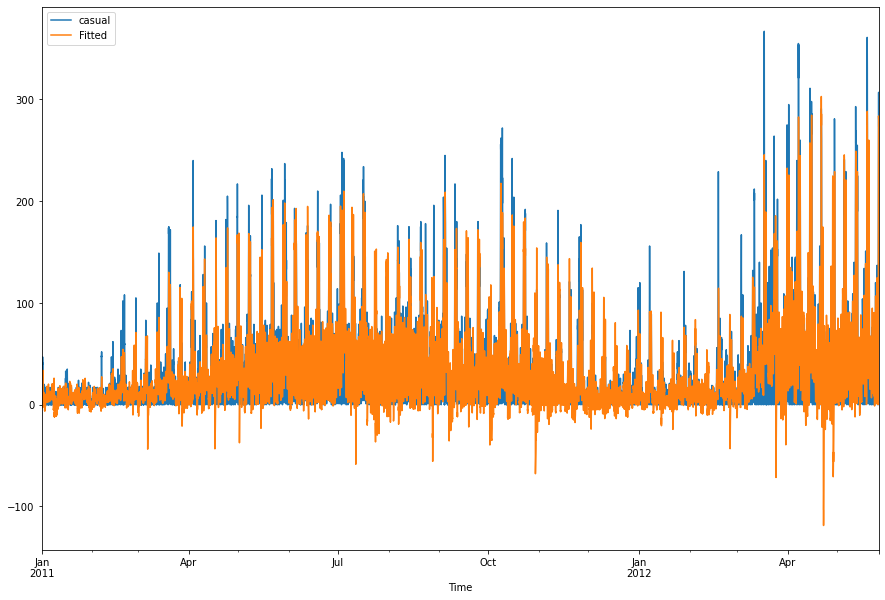

{'smoothing_level': 0.1, 'smoothing_trend': 0.5, 'smoothing_seasonal': 0.5, 'damping_trend': 0.5, 'initial_level': -25.625684976294146, 'initial_trend': 20.50197992757857, 'initial_seasons': array([ 1.73393932e+01,  1.73795914e+01,  1.43875259e+01,  1.14772609e+01,
        8.29544652e+00,  7.92172030e+00,  6.03528424e+00,  4.14255023e+00,
        2.20144456e+00,  4.46346796e+00,  6.61712637e+00,  1.43412230e+01,
        1.71231210e+01,  2.73363937e+01,  2.31871035e+01,  2.40958336e+01,
        2.70890521e+01,  1.15344082e+01,  4.84242285e+00,  3.12988881e+00,
        3.12806560e+00, -8.58670012e-01,  2.67602432e+00,  5.02030258e+00,
       -7.11456117e-01, -3.30295881e+00, -4.29844594e+00, -3.94825008e+00,
       -5.13260978e+00,  1.73514339e+00, -7.67549132e+00, -8.91496508e+00,
       -1.01979394e+01, -1.03699462e+01, -7.52799807e+00, -8.43089458e-01,
        1.29414532e+00, -6.12750128e+00, -1.13398207e+01, -5.05141120e+00,
       -1.17312841e+01, -1.73675280e+01, -1.81271794e+01, -

In [56]:
hw_gs_casual = get_hw(ts_train_casual, **gs_casual_best_params)

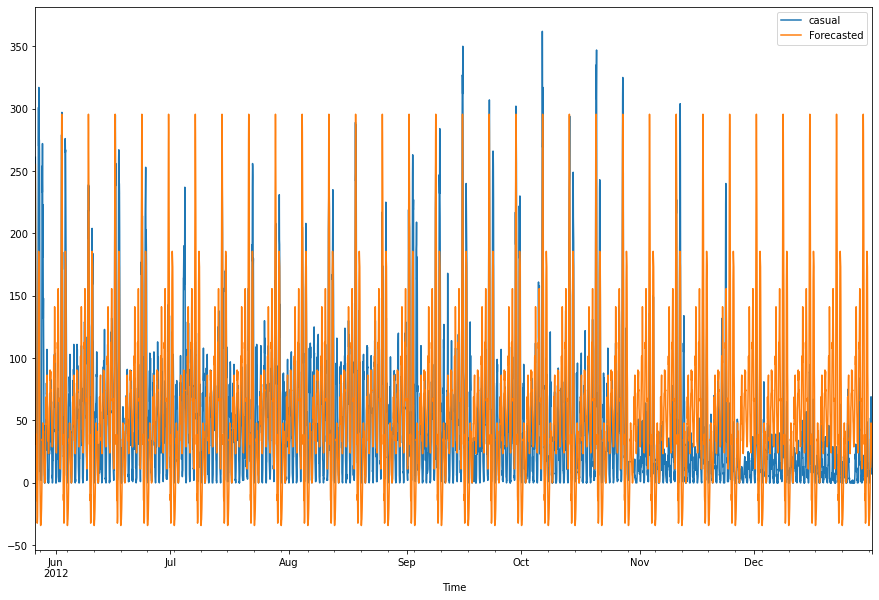

RMSE:  47.1174377991237
MAE:  34.902727802033
R2:  0.33394206148811734


In [57]:
show_hw_fcast_res(hw_gs_casual, ts_test_casual)

#### Registered

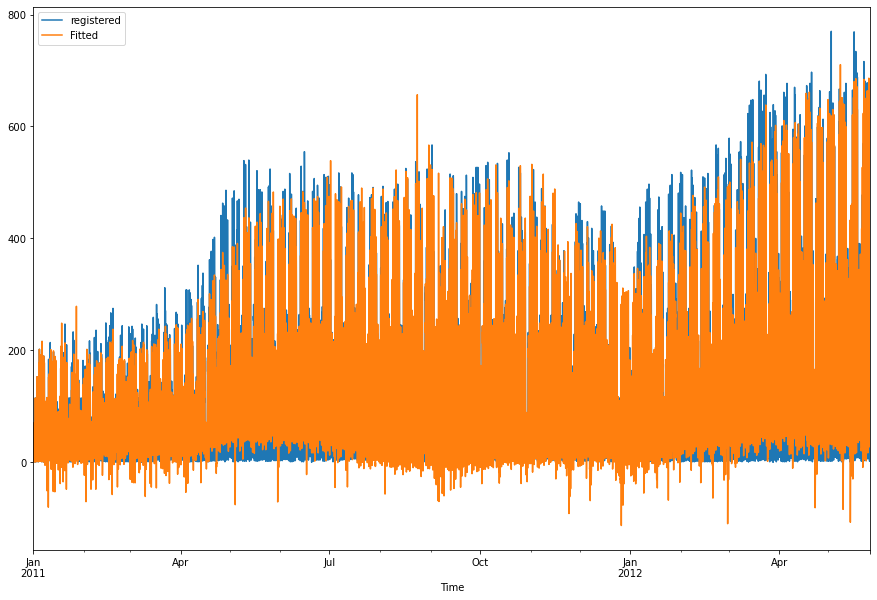

{'smoothing_level': 0.46464285714285714, 'smoothing_trend': 0.0001, 'smoothing_seasonal': 0.35690476190476195, 'damping_trend': 0.99, 'initial_level': 63.891891891891895, 'initial_trend': -0.021400226757369606, 'initial_seasons': array([-5.08918919e+01, -3.18918919e+01, -3.68918919e+01, -5.38918919e+01,
       -6.28918919e+01, -6.28918919e+01, -6.38918919e+01, -6.18918919e+01,
       -5.68918919e+01, -5.78918919e+01, -3.98918919e+01, -3.38918919e+01,
       -8.89189189e+00, -1.68918919e+01,  7.10810811e+00,  6.10810811e+00,
       -1.18918919e+01, -1.18918919e+01, -3.78918919e+01, -3.28918919e+01,
       -3.88918919e+01, -3.28918919e+01, -4.68918919e+01, -3.98918919e+01,
       -5.08918919e+01, -4.78918919e+01, -5.58918919e+01, -5.98918919e+01,
       -6.28918919e+01,  5.11081081e+01, -6.18918919e+01, -6.28918919e+01,
       -5.58918919e+01, -4.48918919e+01, -1.78918919e+01, -9.89189189e+00,
        9.10810811e+00,  1.08108108e-01, -8.89189189e+00, -8.89189189e+00,
        3.10810811e+

In [58]:
ts_train_registered = train[["Time", "registered"]].set_index("Time").asfreq("H").copy()
hw_registered = get_hw(ts_train_registered)

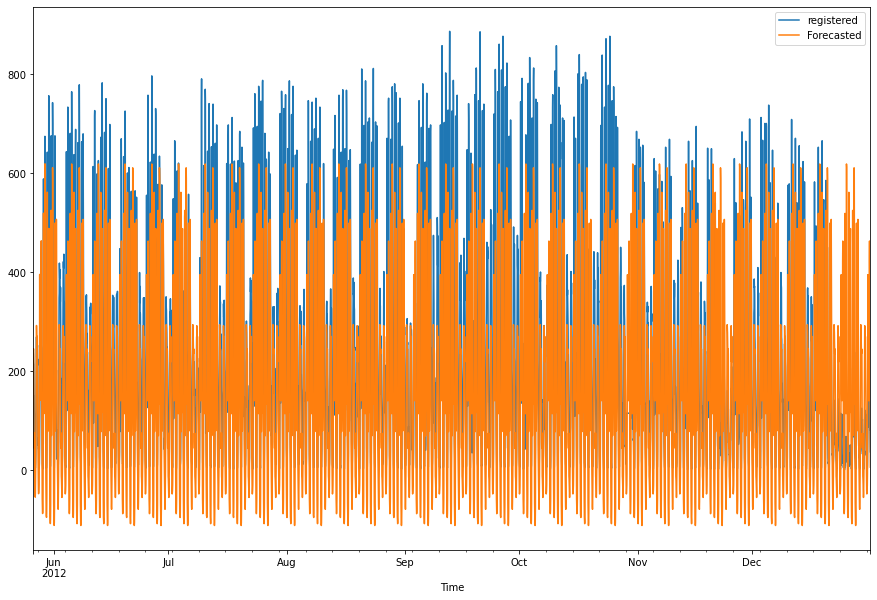

RMSE:  115.41738339160003
MAE:  96.13878823090091
R2:  0.6168713200815822


In [59]:
ts_test_registered = test[["Time", "registered"]].set_index("Time").asfreq("H").copy()
show_hw_fcast_res(hw_registered, ts_test_registered)

In [60]:
print("Mean CV RMSE: ",get_ts_cv(train["registered"]))

Mean CV RMSE:  84.68751679270017


In [61]:
start_time = time.time()
gs_registered_best_params = gscv_hw(train["registered"], grid, 3)
print("--- %s seconds ---" % (time.time() - start_time))

{'damping_trend': 0.5, 'smoothing_level': 0.1, 'smoothing_seasonal': 0.1, 'smoothing_trend': 0.5}


C:\Users\don_f\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\don_f\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\don_f\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


78.6173266130087
{'damping_trend': 0.1, 'smoothing_level': 0.5, 'smoothing_seasonal': 0.9, 'smoothing_trend': 0.9}


C:\Users\don_f\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\don_f\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\don_f\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\don_f\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


107.70335079248805
{'damping_trend': 0.1, 'smoothing_level': 0.5, 'smoothing_seasonal': 0.5, 'smoothing_trend': 0.5}


C:\Users\don_f\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\don_f\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\don_f\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


97.79098209161556
--- 40.18720507621765 seconds ---


C:\Users\don_f\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [62]:
print(gs_registered_best_params)

{'damping_trend': 0.5, 'smoothing_level': 0.1, 'smoothing_seasonal': 0.1, 'smoothing_trend': 0.5}


C:\Users\don_f\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


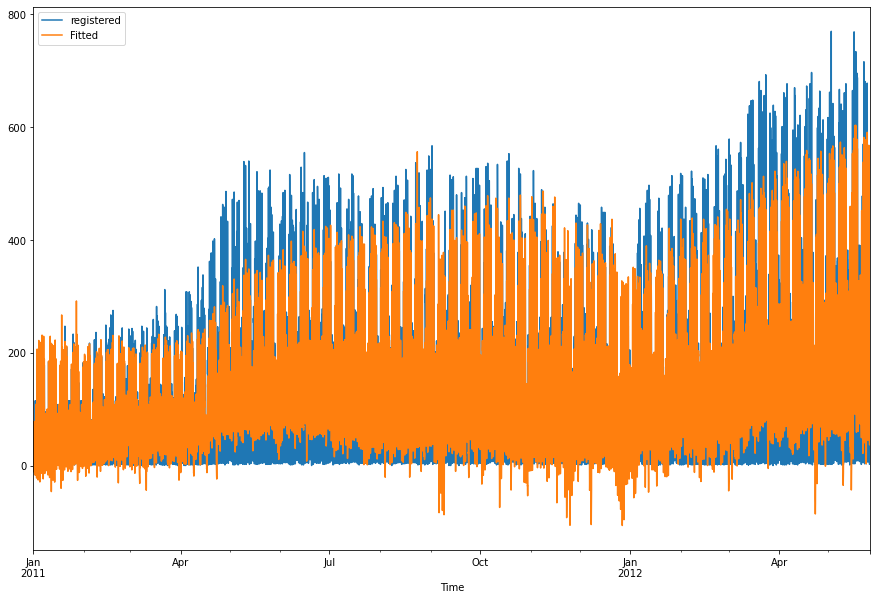

{'smoothing_level': 0.1, 'smoothing_trend': 0.5, 'smoothing_seasonal': 0.1, 'damping_trend': 0.5, 'initial_level': 158.19148105021924, 'initial_trend': -88.85586243973958, 'initial_seasons': array([-76.81834325, -78.92652782, -81.9874265 , -88.75723468,
       -89.69319307, -67.66713305, -77.55033663, -65.66941444,
       -41.24581418, -26.26313014,  -1.88052947,   9.98228957,
        23.38432229,  23.07394134,  23.04051201,  24.57529555,
        18.42891261,   6.04870323,  -5.59816037, -23.28781332,
       -42.39239662, -48.58379406, -58.09446576, -62.64652775,
       -67.54559995, -74.52879051, -74.85921001, -86.49599363,
       -80.56203322, -47.52553242, -70.00660275, -69.39748282,
       -50.70218185, -27.98939517,   7.87067893,  20.56999222,
        43.00414881,  40.22239225,  31.17113744,  29.86506251,
        27.45726206,  13.17430994,  -7.19852163, -29.23825007,
       -46.96874481, -58.99159229, -64.86394102, -73.01197523,
       -81.8286078 , -85.36975339, -53.60580518, -64.

In [63]:
hw_gs_registered = get_hw(ts_train_registered, **gs_registered_best_params)

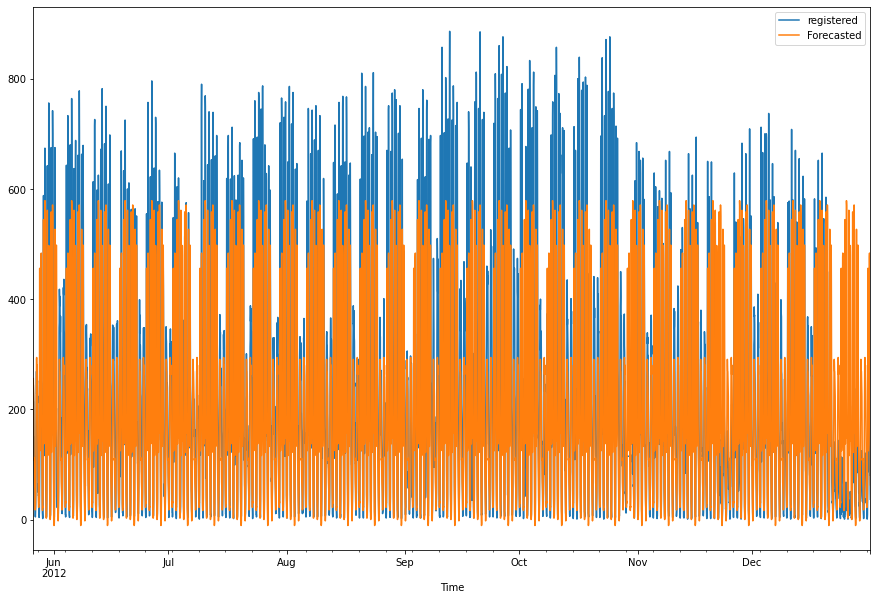

RMSE:  92.37647665099807
MAE:  62.61102518805496
R2:  0.7545714948797599


In [64]:
show_hw_fcast_res(hw_gs_registered, ts_test_registered)

#### Holt Winters Discussion
These models produced through Holt Winters Exponential Smoothing perform reasonably well. Conducting a grid search to find the best smoothing levels further improves performance. The plots of forecasted against actual values show that forecasted values reasonably follow the trend of actual observed values.
<br>
<br>
It is important to note that the Grid search did not check all combinations of hyperparameters in the interest of time. Hence, some resultant models from returned hyperparameters did not converge. Running a full grid search or increasing the number of random combinations tried is likely to alleviate this issue while also producing better performing models.

# SARIMAX

#### Casual

In [65]:
smx_X_train = train.copy()
smx_X_train = smx_X_train.drop(columns=["Date2", "yr", "mnth", "day", "hr", "total", "casual", "registered", "temp"])

smx_X_test = test.copy()
smx_X_test = smx_X_test.drop(columns=["Date2", "yr", "mnth", "day", "hr", "total", "casual", "registered", "temp"])

# Making dummy variables
categorical_vars = ["season", "weathersit"]

dummies = pd.get_dummies(bike_clean[categorical_vars].astype(str), drop_first=True)

dummies_train = dummies.iloc[:n_rows_train -1 , :]
smx_X_train = smx_X_train.join(dummies_train).drop(columns=categorical_vars)

dummies_test = dummies.iloc[n_rows_train - 1:, :]
smx_X_test = smx_X_test.join(dummies_test).drop(columns=categorical_vars)

smx_X_train = smx_X_train.set_index("Time").asfreq("H")
smx_X_test = smx_X_test.set_index("Time").asfreq("H")

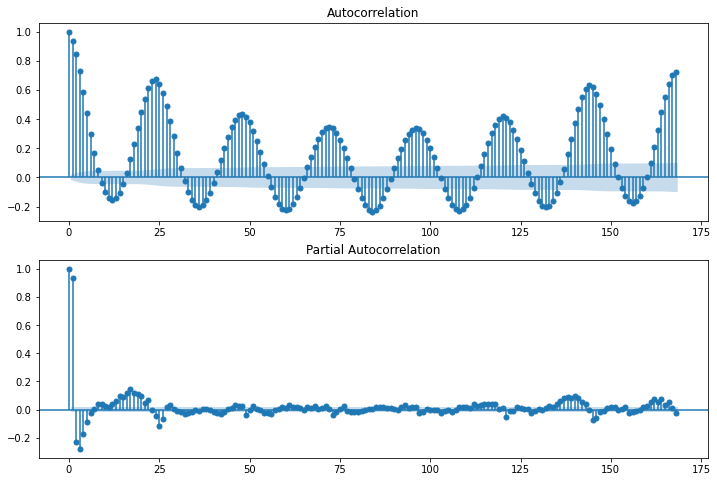

In [66]:
# ACF and PACF to get rough ideas of pdq and pdqm
def get_acf_pacf(ts_data):
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = plot_acf(ts_data, lags=24*7, ax=ax1) # 
    ax2 = fig.add_subplot(212)
    fig = plot_pacf(ts_data, lags=24*7, ax=ax2)# , lags=48

    plt.show()
    
get_acf_pacf(ts_train_casual)

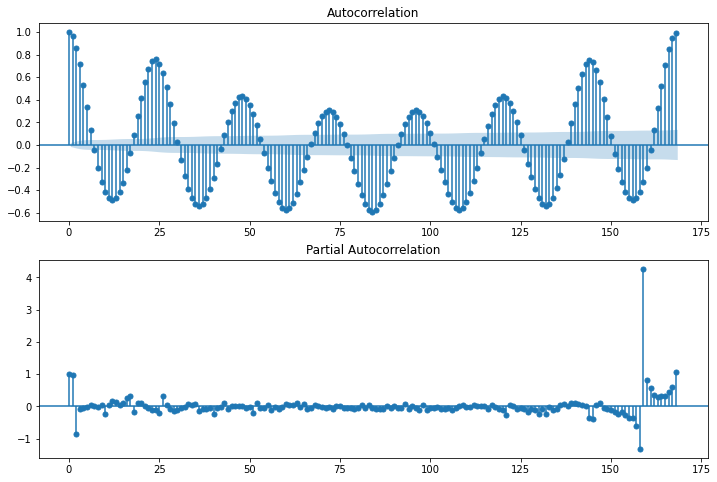

In [67]:
get_acf_pacf(sd_casual.seasonal)

In [68]:
adfuller(sd_casual.seasonal)

(-22.749171324246635,
 0.0,
 40,
 12239,
 {'1%': -3.430884412292472,
  '5%': -2.861776183202108,
  '10%': -2.5668957152963654},
 60589.785926813915)

In [69]:
# SARIMXAX


def get_smx(ts_data, order, seasonal_order):
    smx = SARIMAX(ts_data, exog=smx_X_train, order=order, seasonal_order=seasonal_order, 
                  simple_differencing=True).fit(method="lbfgs")
    
    ts_data.plot(figsize=(15,10), label="Actual")
    smx.fittedvalues.plot(figsize=(15,10), label="Fitted")
    plt.legend()
    plt.show()
    
    score_model_train(smx)
    
    return smx

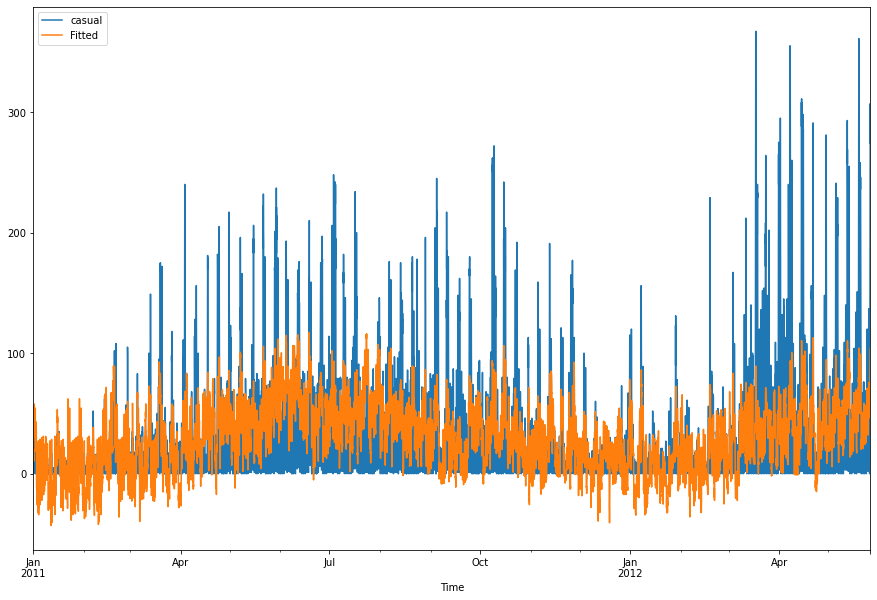

RMSE:  33.78659186125146
MAE:  22.512906349966904
R2:  -0.3726604191852714


In [70]:
# For order,
# According to ADF, already stationary so d = 0
# From ACF and PACF, p=24*6, q=24
# For seasonal_order,
# From ADF, d = 0
# From ACF and PACF, p=24*6, q=24*6
# M = 24*7

smx_casual = get_smx(ts_train_casual, (0,0,0), (0,0,0,24*7))

In [71]:
print(smx_casual.summary())

                               SARIMAX Results                                
Dep. Variable:                 casual   No. Observations:                12280
Model:                        SARIMAX   Log Likelihood              -60650.952
Date:                Sat, 16 Apr 2022   AIC                         121327.903
Time:                        16:13:06   BIC                         121424.307
Sample:                    01-01-2011   HQIC                        121360.205
                         - 05-26-2012                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
holiday           -9.7938      1.727     -5.671      0.000     -13.179      -6.409
weekday            1.2808      0.116     11.006      0.000       1.053       1.509
workingday       -29.7554      0.736

In [72]:
# Helper function to show forecast results, given the sarimax model and test data
def show_smx_fcast_res(smx, test):
    pred_test = smx.predict(start=test.index[0], end=test.index[-1], exog=smx_X_test)
    
    test.plot(figsize=(15,10), label="Actual")
    pred_test.plot(figsize=(15,10), label="Forecasted")
    plt.legend()
    plt.show()

    score_model_test(smx, test.iloc[:, -1], smx_X_test)

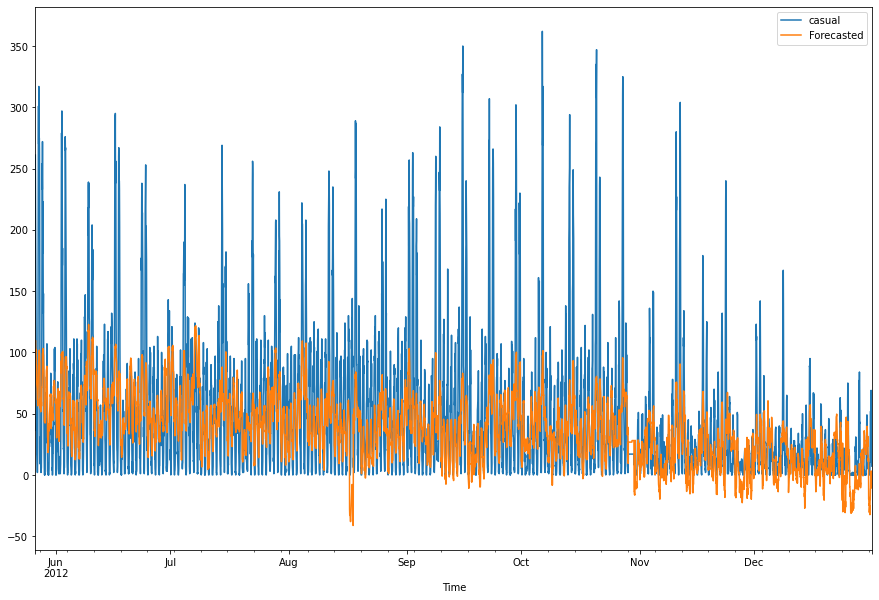

RMSE:  45.917986667852176
MAE:  29.734982609886718
R2:  0.36742160893373266
Adjusted R2:  0.3659759908242688


In [73]:
show_smx_fcast_res(smx_casual, ts_test_casual)

#### Registered

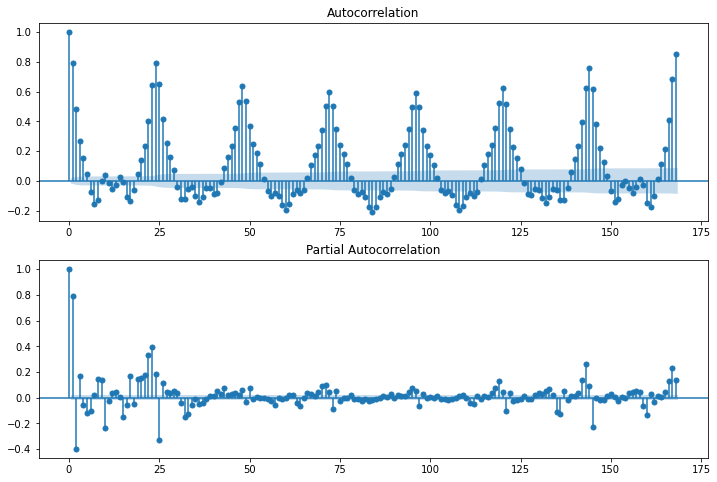

In [74]:
get_acf_pacf(ts_train_registered)

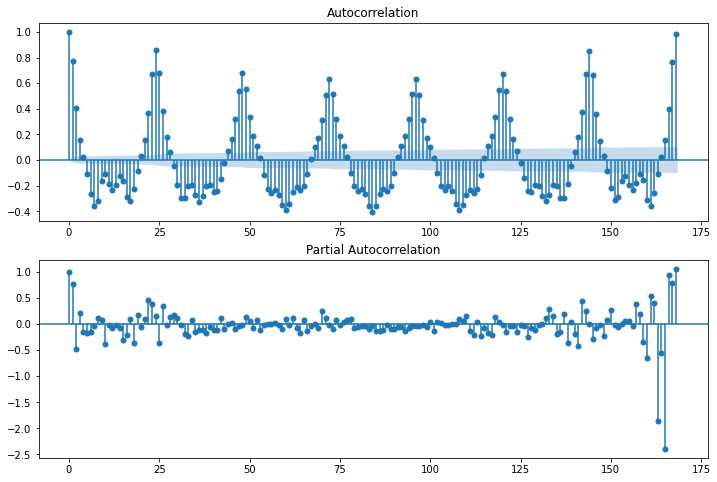

In [75]:
get_acf_pacf(sd_registered.seasonal)

In [76]:
adfuller(sd_registered.seasonal)

(-24.311364247556035,
 0.0,
 40,
 12239,
 {'1%': -3.430884412292472,
  '5%': -2.861776183202108,
  '10%': -2.5668957152963654},
 114007.74595914083)

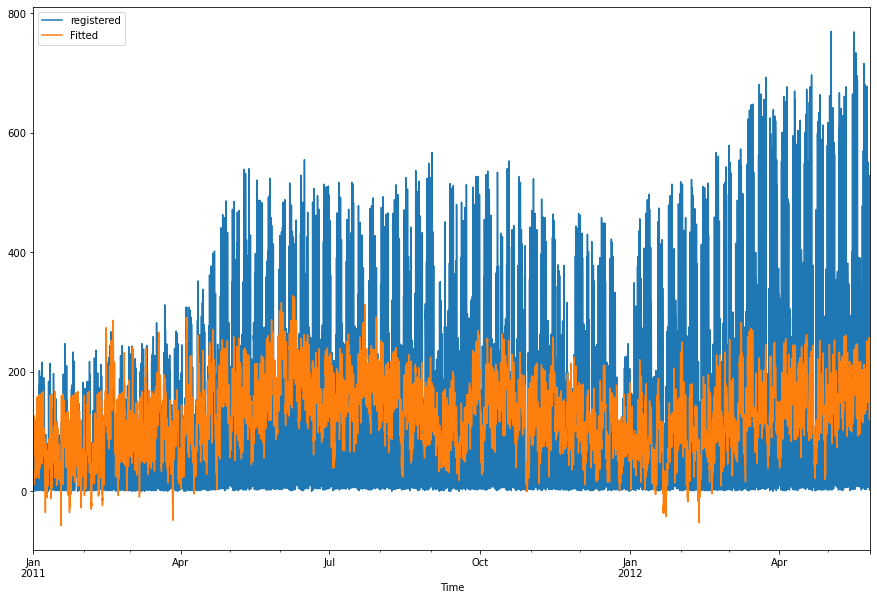

RMSE:  111.41811403464403
MAE:  81.04245766019262
R2:  -2.380160869802456


In [77]:
smx_registered = get_smx(ts_train_registered, (0,0,0), (0,0,0,24*7))

In [78]:
print(smx_registered.summary())

                               SARIMAX Results                                
Dep. Variable:             registered   No. Observations:                12280
Model:                        SARIMAX   Log Likelihood              -75303.765
Date:                Sat, 16 Apr 2022   AIC                         150633.531
Time:                        16:13:22   BIC                         150729.935
Sample:                    01-01-2011   HQIC                        150665.833
                         - 05-26-2012                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
holiday           -0.7761      9.106     -0.085      0.932     -18.623      17.071
weekday            2.3959      0.597      4.013      0.000       1.226       3.566
workingday        35.9288      3.123

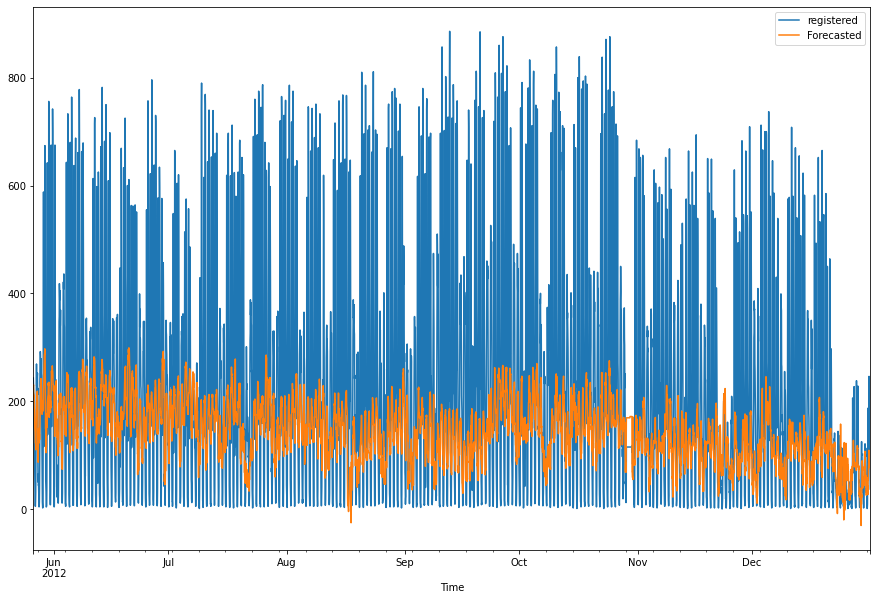

RMSE:  182.96511702459574
MAE:  125.43400228481194
R2:  0.037193950735992964
Adjusted R2:  0.03499367029585432


In [79]:
show_smx_fcast_res(smx_registered, ts_test_registered)

#### SARIMAX Discussion
The models produced through SARIMAX do not perform as well as the models from Holt Winters. 
<br>
<br>
However, this is likely because non-optimal values of p, d, q, and P, D, Q, M were set. The ACF and PACF plots indicated that more reasonable values of those hyperparameters are likely to be quite large, leading to extremely long time needed for the model to converge. As such, in the interest of time, all "order" and "seasonal_order" hyperparameters (except for M) were set to 0.

# Overall Discussion
Holt Winters models had the best predictive power. Nonetheless, Poisson GLM and SARIMAX models which account for exogenous variables allow for better interpretability on how those exogenous factors may affect demand.